# Generic Pseudo-labeling for Domain Adaptation in Deep Computer Vision

## Modern Office Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import lib.data
import lib.torch_train_eval
import lib.adaptive_train_eval

import tasks.preprocessing
import tasks.utils
import tasks.results

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output/office"

RANDOM_SEED = 42
BATCH_SIZE = 1
PRINT_STATS_PERIOD = 500

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1


TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

RHO = 4
SAMPLING_PERIOD = 20


FINETUNED_SOURCE__MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
FINETUNED_TARGET_MODEL_DIR = os.path.join(OUTPUT_DIR, "target_classifier")
UNSUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "unsupervised")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-20")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-20")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-10")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-10")

FINETUNE_SOURCE_MODEL = False
FINETUNE_TARGET_MODEL = True
TRAIN_UNSUPERVISED_MODEL = False
FINETUNE_SEMI_SUPERVISED_MODEL_20 = False
TRAIN_SEMI_SUPERVISED_MODEL_20 = False
FINETUNE_SEMI_SUPERVISED_MODEL_10 = False
TRAIN_SEMI_SUPERVISED_MODEL_10 = False

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataset preprocessing

In [2]:
source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = (
    lib.data.train_val_test_split(
        source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

source_train_loader = tasks.preprocessing.single_batch_loader(
    source_train_dataset, shuffle=True
)
source_val_loader = tasks.preprocessing.single_batch_loader(
    source_val_dataset, shuffle=False
)
source_test_loader = tasks.preprocessing.single_batch_loader(
    source_test_dataset, shuffle=False
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [3]:
target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=source_dataset.label_encoder,  # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = (
    lib.data.train_val_test_split(
        target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

target_train_loader = tasks.preprocessing.single_batch_loader(
    target_train_dataset, shuffle=True
)
target_val_loader = tasks.preprocessing.single_batch_loader(
    target_val_dataset, shuffle=False
)
target_test_loader = tasks.preprocessing.single_batch_loader(
    target_test_dataset, shuffle=False
)

  0%|          | 0/31 [00:00<?, ?it/s]

In [4]:
unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
unlabeled_dataset_20.load_from_image_dataset(target_train_dataset)

In [5]:
to_be_unlabeled_dataset_20, labeled_dataset_20 = lib.data.stratified_split(
    target_train_dataset, test_size=0.2
)

unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_20.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_20.load_from_image_dataset(to_be_unlabeled_dataset_20)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_20.add(sample_img, sample_label)

len(labeled_dataset_20), len(source_train_dataset)

(2224, 2112)

In [6]:
to_be_unlabeled_dataset_10, labeled_dataset_10 = lib.data.stratified_split(
    target_train_dataset, test_size=0.1
)

unlabeled_dataset_10 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_10.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_10.load_from_image_dataset(to_be_unlabeled_dataset_10)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_10.add(sample_img, sample_label)

len(labeled_dataset_10), len(source_train_dataset)

(2168, 2112)

In [7]:
class_names = source_train_dataset.label_encoder.classes_

encodings = {
    label: class_name
    for label, class_name in enumerate(source_train_dataset.label_encoder.classes_)
}

### Source-only model

In [8]:
import torchinfo


def get_model(replace_fc_layer: bool=False, num_classes: int=0) -> nn.Module:
    model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT").to(
        device
    )
    if replace_fc_layer:
        model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
    return model



criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
#https://arxiv.org/pdf/2405.13698
# disable lr for adam
exp_lr_scheduler = None


torchinfo.summary(get_model(), input_size=(BATCH_SIZE, 3, 1500, 1500))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 750, 750]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 750, 750]         128
├─ReLU: 1-3                              [1, 64, 750, 750]         --
├─MaxPool2d: 1-4                         [1, 64, 375, 375]         --
├─Sequential: 1-5                        [1, 64, 375, 375]         --
│    └─BasicBlock: 2-1                   [1, 64, 375, 375]         --
│    │    └─Conv2d: 3-1                  [1, 64, 375, 375]         36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 375, 375]         128
│    │    └─ReLU: 3-3                    [1, 64, 375, 375]         --
│    │    └─Conv2d: 3-4                  [1, 64, 375, 375]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 375, 375]         128
│    │    └─ReLU: 3-6                    [1, 64, 375, 375]         --
│

In [ ]:
model = get_model()

if FINETUNE_SOURCE_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(FINETUNED_SOURCE__MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_SOURCE__MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=5,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD
    )
else:
    history = tasks.utils.try_load_history(os.path.join(FINETUNED_SOURCE__MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Target only model

In [13]:
model = get_model(replace_fc_layer=True, num_classes=len(encodings))

if FINETUNE_TARGET_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_TARGET_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=10e-3)

    history = tasks.utils.try_load_history(os.path.join(FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        target_train_loader,
        target_val_loader,
        output_dir=FINETUNED_TARGET_MODEL_DIR,
        num_epochs=100,
        patience=10,
        warmup_period=25,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=20000,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_TARGET_MODEL_DIR, "model.pt"))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


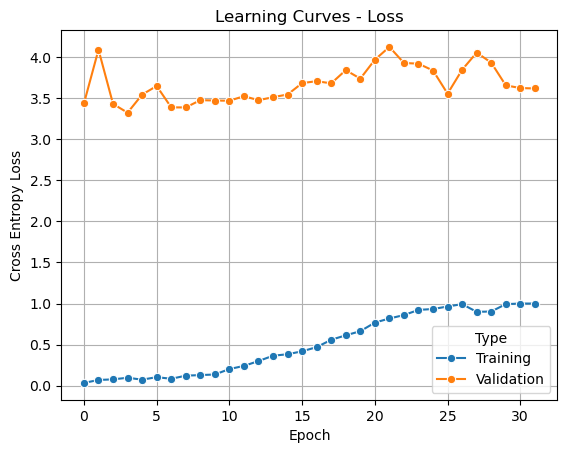

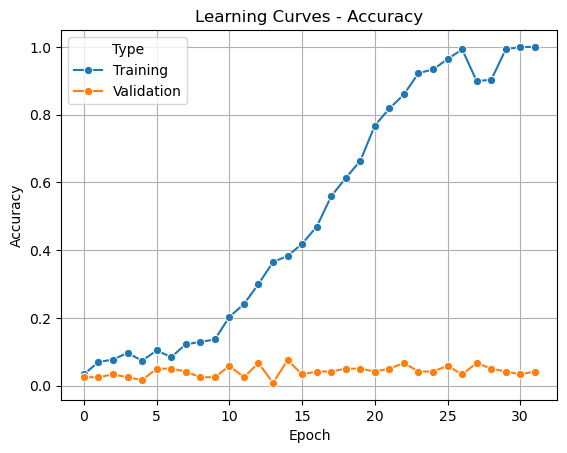

In [14]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [15]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

  0%|          | 0/120 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.00      0.00      0.00         5
            bike       0.00      0.00      0.00         2
     bike_helmet       0.04      0.50      0.08         4
        bookcase       0.00      0.00      0.00         1
          bottle       0.00      0.00      0.00         2
      calculator       0.00      0.00      0.00         4
      desk_chair       0.00      0.00      0.00        10
       desk_lamp       0.00      0.00      0.00         5
desktop_computer       0.00      0.00      0.00         2
    file_cabinet       0.00      0.00      0.00         3
      headphones       0.00      0.00      0.00         4
        keyboard       0.00      0.00      0.00         1
 laptop_computer       0.00      0.00      0.00         5
     letter_tray       0.00      0.00      0.00         2
    mobile_phone       0.00      0.00      0.00         5
         monitor       0.00      0.00      0.00         6
           mo

### Unsupervised Domain Adaptation

https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/pseudo-labeling-to-deal-with-small-datasets-what-why-how-fd6f903213af

https://stats.stackexchange.com/questions/364584/why-does-using-pseudo-labeling-non-trivially-affect-the-results

https://www.sciencedirect.com/science/article/abs/pii/S1077314222001102

In [ ]:
model = get_model()

if TRAIN_UNSUPERVISED_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(UNSUPERVISED_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())
    
    source_history = tasks.utils.try_load_history(os.path.join(UNSUPERVISED_MODEL_DIR, "source_history.pickle"))
    target_history = tasks.utils.try_load_history(os.path.join(UNSUPERVISED_MODEL_DIR, "target_history.pickle"))
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_20,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, UNSUPERVISED_MODEL_DIR)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Semi-supervised domain adaptation: 20% target data

In [ ]:
model = get_model()

if FINETUNE_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_20, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=history
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [ ]:
model = get_model()

if TRAIN_SEMI_SUPERVISED_MODEL_20:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    source_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "source_history.pickle"))
    target_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "target_history.pickle"))
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_20,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.single_batch_loader(
                dataset, sampler=sampler, shuffle=False
            ),
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Semi-supervised domain adaptation: 10% target data

In [ ]:
model = get_model()

if FINETUNE_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_10, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=None,
    )
else:
    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [ ]:
model = get_model()

if TRAIN_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    source_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10, "source_history.pickle"))
    target_history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10, "target_history.pickle"))
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_10,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_10,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=None,
            previous_target_history=None,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

## Adaptiope dataset

In [ ]:
BATCH_SIZE = 1
PRINT_STATS_PERIOD = 500

AD_DATA_DIR = "data/adaptiope"
AD_OUTPUT_DIR = "output/adaptiope"

AD_SOURCE_DATASET = "product_images"
AD_TARGET_DATASET = "real_life"

AD_FINETUNED_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "classifier")
AD_UNSUPERVISED_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "unsupervised")
AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-finetuned-20")
AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-adaptive-20")
AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-finetuned-10")
AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10 = os.path.join(AD_OUTPUT_DIR, "semi-supervised-adaptive-10")

AD_FINETUNE_MODEL = False
AD_TRAIN_UNSUPERVISED_MODEL = False
AD_FINETUNE_SEMI_SUPERVISED_MODEL_20 = False
AD_TRAIN_SEMI_SUPERVISED_MODEL_20 = False
AD_FINETUNE_SEMI_SUPERVISED_MODEL_10 = False
AD_TRAIN_SEMI_SUPERVISED_MODEL_10 = False

### Dataset preprocessing

In [ ]:
ad_source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_source_dataset.load_from_directory(os.path.join(AD_DATA_DIR, AD_SOURCE_DATASET))

ad_source_train_dataset, ad_source_val_dataset, ad_source_test_dataset = (
    lib.data.train_val_test_split(
        ad_source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

ad_source_train_loader = tasks.preprocessing.single_batch_loader(
    ad_source_train_dataset, shuffle=True
)
ad_source_val_loader = tasks.preprocessing.single_batch_loader(
    ad_source_val_dataset, shuffle=False
)
ad_source_test_loader = tasks.preprocessing.single_batch_loader(
    ad_source_test_dataset, shuffle=False
)

In [ ]:
ad_target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=ad_source_dataset.label_encoder,  # use same classes
)
ad_target_dataset.load_from_directory(os.path.join(AD_DATA_DIR, AD_TARGET_DATASET))

ad_target_train_dataset, ad_target_val_dataset, ad_target_test_dataset = (
    lib.data.train_val_test_split(
        ad_target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

ad_target_train_loader = tasks.preprocessing.single_batch_loader(
    ad_target_train_dataset, shuffle=True
)
ad_target_test_loader = tasks.preprocessing.single_batch_loader(
    ad_target_test_dataset, shuffle=False
)

In [ ]:
class_names = ad_source_train_dataset.label_encoder.classes_

encodings = {
    label: class_name
    for label, class_name in enumerate(ad_source_train_dataset.label_encoder.classes_)
}

### Source-only model

In [ ]:
import torchinfo


model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT").to(
    device
)
model.fc = nn.Linear(model.fc.in_features, len(set(encodings))).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
#https://arxiv.org/pdf/2405.13698
optimizer_ft = optim.AdamW(model.parameters(), weight_decay=0.0005)
# disable lr for adam
exp_lr_scheduler = None


torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

In [ ]:
if AD_FINETUNE_MODEL:
    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))
        
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        ad_source_train_loader,
        ad_source_val_loader,
        output_dir=AD_FINETUNED_MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=5,
        gradient_accumulation=3,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))

In [ ]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

In [ ]:
history["train_loss"]

In [ ]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)